There are some points we need to pay attention to before getting started.


*   This notebook is run without GPU. With GPU, there will be an error "OOM when 
allocating tensor with shape []". I haven't figured out a way to solve yet. Please let me know if you have an idea.
*   Due to the limit of time and memory, the U-net model is not deep as expected. Also, I only feed in 280 images and train the model in 20 epochs.
*   The result, however, is still acceptable after all. The model is able to detect the tumour. I believe that you can improve it if more data is fed in and trained longer with a deeper model.






### Import packages

In [2]:
import numpy as np
import keras
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm

### Rearrange data and define loader functions

In [3]:
image_data_path = './drive/MyDrive/Brain Tumour/Task01_BrainTumour/imagesTr/'
label_data_path = './drive/MyDrive/Brain Tumour/Task01_BrainTumour/labelsTr/'

image_paths = [image_data_path + name 
               for name in os.listdir(image_data_path) 
               if not name.startswith(".")]

label_paths = [label_data_path + name
               for name in os.listdir(label_data_path)
               if not name.startswith(".")]

image_paths = sorted(image_paths)
label_paths = sorted(label_paths)

len(image_paths), len(label_paths)

(484, 484)

Since the data is heavy, we want to crop images and use "informative area" only. See "Check for informative range" section at the end to know where the below numbers are from. Running the section might take time.

In [4]:
start_layer = 7
end_layer = 146 # 140
start_height = 34
end_height = 203 # 170
start_width = 20
end_width = 209 # 190

In [5]:
def load_one_sample(image_path, label_path):

  image = nib.load(image_path).get_fdata().astype('float32')
  label = nib.load(label_path).get_fdata().astype(np.int64)  # the original dtype is float64

  return image, label

def preprocess_from_path(image_path, label_path):

  image, label = load_one_sample(image_path, label_path)

  image = image[start_height:end_height+1, start_width:end_width+1, start_layer:end_layer+1, :]
  image = np.reshape(image, (170, 190, 140 * 4))
  image = [cv2.resize(image[:, :, i], (95, 85)) for i in range(560)]
  image = np.reshape(image, (140, 4, 85, 95))
  image = np.moveaxis(image, 1, 3)

  label = label[start_height:end_height+1, start_width:end_width+1, start_layer:end_layer+1]
  label = [cv2.resize(label[:, :, i] + np.ones((170, 190)), (95, 85)) for i in range(140)]
  label = [np.array(label)[i, :, :] - np.ones((85, 95)) for i in range(140)]
  label = np.array(label)
  label = np.expand_dims(label, 3).astype(np.int64)

  return image, label

(140, 85, 95, 4) (140, 85, 95, 1) <class 'numpy.ndarray'>


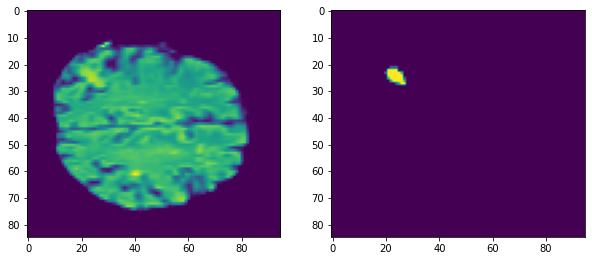

In [6]:
image_example, label_example = preprocess_from_path(image_paths[9], label_paths[9])
print(image_example.shape, label_example.shape, type(label_example))

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_example[100, :, :, 0])
plt.subplot(1, 2, 2)
plt.imshow(label_example[100, :, :, 0])

In [7]:
# label_example

### TFRecord

In [8]:
def image_feature(value):
  return tf.train.Feature(bytes_list = tf.train.BytesList(value = value)) ##

def float_feature(value):
  return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def int64_feature(value):
  return tf.train.Feature(int64_list = tf.train.Int64List(value = value))

def create_example(image_path, label_path):
  image, label = preprocess_from_path(image_path, label_path)
  image, label = image.ravel(), label.ravel()
  feature = {'image': float_feature(image),
             'label': int64_feature(label)}
  example = tf.train.Example(features = tf.train.Features(feature = feature))
  return example

def parse_tfrecord(example):
  feature = {'image': tf.io.FixedLenFeature([140, 85, 95, 4], tf.float32),
             'label': tf.io.FixedLenFeature([140, 85, 95, 1], tf.int64)}
  parsed_example = tf.io.parse_single_example(example, feature)
  return parsed_example

In [9]:
tf.config.run_functions_eagerly(True)

In [10]:
train_writer = tf.io.TFRecordWriter('train.tfrecords')
valid_writer = tf.io.TFRecordWriter('valid.tfrecords')

for i in range(1,2):
  example = create_example(image_paths[i], label_paths[i])
  train_writer.write(example.SerializeToString())
train_writer.close()

for i in range(2,3):
  example = create_example(image_paths[i], label_paths[i])
  valid_writer.write(example.SerializeToString())
valid_writer.close()

serialised_train_set = tf.data.TFRecordDataset('train.tfrecords')
serialised_valid_set = tf.data.TFRecordDataset('valid.tfrecords')

serialised_train_set = serialised_train_set.map(parse_tfrecord)
serialised_valid_set = serialised_valid_set.map(parse_tfrecord)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


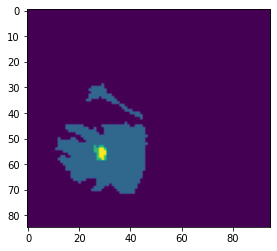

In [11]:
for features in serialised_valid_set.take(100):
  plt.imshow(features['label'][90, :, :, 0])

In [12]:
for features in serialised_valid_set.take(100):
  print(features['label'].shape)

(140, 85, 95, 1)


### Model

In [13]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Rescaling

num_classes = 4

unet_beginner_version = tf.keras.Sequential([

Input(shape = (85, 95, 4), name = 'image'),
Rescaling(scale = 1./255),
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2D(filters = 256, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
#Conv2D(filters = 512, kernel_size = 3, activation = 'relu', strides = 1, padding = 'same'),
#Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same'),
#Conv2D(filters = 1024, kernel_size = 3, activation = 'relu', strides = 1, padding = 'same'),
#Conv2D(filters = 1024, kernel_size = 3, activation = 'relu', padding = 'same'),

#Conv2DTranspose(filters = 1024, kernel_size = 3, activation = 'relu', padding = 'same'),
#Conv2DTranspose(filters = 1024, kernel_size = 3, activation = 'relu', strides = 1, padding = 'same'),
#Conv2DTranspose(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same'),
#Conv2DTranspose(filters = 512, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 256, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),


Conv2D(filters = num_classes, kernel_size = 3, activation = 'softmax', padding = 'same')

])

In [ ]:
# unet_beginner_version.summary()

In [14]:
unet_beginner_version.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

In [15]:
def get_image_and_label(features):
  image, label = features['image'], features['label']
  return image, label

def get_dataset(tfrecord_names):

  dataset = (tf.data.TFRecordDataset(tfrecord_names)
             .map(parse_tfrecord)
             .map(get_image_and_label))

  return dataset

In [ ]:
train_set = get_dataset('train.tfrecords')
valid_set = get_dataset('valid.tfrecords')

callback = tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/test.h5')

#unet_beginner_version = tf.keras.models.load_model('drive/MyDrive/test.h5')

history = unet_beginner_version.fit(train_set,
                          validation_data = valid_set,
                          callbacks = callback,
                          batch_size = 16,
                          epochs = 20)

Epoch 1/20
1/1 [==============================] - 490s 490s/step - loss: 1.3799 - val_loss: 1.1486
Epoch 2/20
1/1 [==============================] - 524s 524s/step - loss: 0.8903 - val_loss: 0.9753
Epoch 3/20
1/1 [==============================] - 501s 501s/step - loss: 0.9567 - val_loss: 1.5001
Epoch 4/20
1/1 [==============================] - 470s 470s/step - loss: 0.7266 - val_loss: 0.8673
Epoch 5/20
1/1 [==============================] - 490s 490s/step - loss: 0.3970 - val_loss: 0.3026
Epoch 6/20
1/1 [==============================] - 487s 487s/step - loss: 0.1634 - val_loss: 0.1857
Epoch 7/20
1/1 [==============================] - 486s 486s/step - loss: 0.0716 - val_loss: 0.1592
Epoch 8/20
1/1 [==============================] - 457s 457s/step - loss: 0.0588 - val_loss: 0.1853
Epoch 9/20
1/1 [==============================] - 496s 496s/step - loss: 0.0534 - val_loss: 0.1299
Epoch 10/20
1/1 [==============================] - 492s 492s/step - loss: 0.0432 - val_loss: 0.1516
Epoch 11/

In [16]:
unet_beginner_version = tf.keras.models.load_model('drive/MyDrive/test.h5')

In [19]:
def show_result(image_path, label_path, layer):

  one_image, one_label = preprocess_from_path(image_path, label_path)
  predicted_label = unet_beginner_version.predict(np.expand_dims(one_image[layer, :, :, :], 0))[0]

  # plot and compare the result

  plt.figure(figsize = (20, 5))

  plt.subplot(1, 4, 1)
  plt.imshow(one_image[layer, :, :, 0])
  plt.title('Image example')
  plt.axis('off')

  plt.subplot(1, 4, 2)
  plt.imshow(one_label[layer, :, :, 0])
  plt.title('Ground Truth')
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.imshow(predicted_label[:, :, 3])
  plt.title('Predicted Image')
  plt.axis('off')

  plt.subplot(1, 4, 4)
  plt.imshow(np.argmax(predicted_label, axis = -1))
  plt.axis('off')

  plt.savefig('drive/MyDrive/mypic')

  return predicted_label


(85, 95, 4)

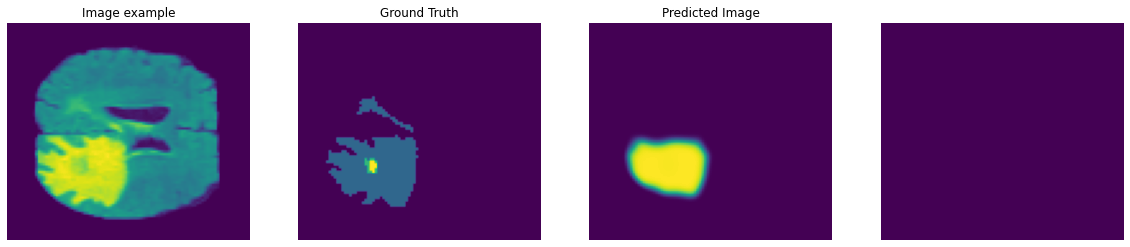

In [20]:
predicted_label = show_result(image_paths[2], label_paths[2], 90)
predicted_label.shape

It's not bad at all with 280 instances in total, is it?

### Check for informative range (This might take time)

In [ ]:
def check_informative_layers_range_by_images(image_example):
  informative_layers = []
  for i in range(155):
    unique_numbers = np.unique(image_example[:, :, i, :])
    if len(unique_numbers) == 1:
      pass
    else:
      informative_layers.append(i)
  informative_layers_range = np.array([[informative_layers[0], informative_layers[-1]]])
  return informative_layers_range

def check_informative_layers_range_by_labels(label_example):
  informative_layers = []
  for i in range(155):
    unique_numbers = np.unique(label_example[:, :, i])
    if len(unique_numbers) == 1:
      pass
    else:
      informative_layers.append(i)
  informative_layers_range = np.array([[informative_layers[0], informative_layers[-1]]])
  return informative_layers_range

In [ ]:
def check_informative_height_range(image_example):
  informative_height_range = []
  for i in range(240):
    number_of_unique_numbers = len(np.unique(image_example[i, :, :, :]))
    if number_of_unique_numbers == 1:
      pass
    else:
      informative_height_range.append(i)
  informative_height_range = np.array([[informative_height_range[0], informative_height_range[-1]]])
  return informative_height_range

def check_informative_width_range(image_example):
  informative_width_range = []
  for i in range(240):
    number_of_unique_numbers = len(np.unique(image_example[:, i, :, :]))
    if number_of_unique_numbers == 1:
      pass
    else:
      informative_width_range.append(i)
  informative_width_range = np.array([[informative_width_range[0], informative_width_range[-1]]])
  return informative_width_range

In [ ]:
informative_layers_all_examples = np.empty((484, 2))
informative_height_all_examples = np.empty((484, 2))
informative_width_all_examples = np.empty((484, 2))

for i in range(484):
  
  image_example, label_example = load_one_sample(image_paths[i], label_paths[i])

  informative_layers_all_examples[i] = check_informative_layers_range_by_labels(label_example)
  informative_height_all_examples[i] = check_informative_height_range(image_example) 
  informative_width_all_examples[i] = check_informative_width_range(image_example)


KeyboardInterrupt: ignored

In [ ]:
acceptable_layer_range = [informative_layers_all_examples.min(axis = 0)[0], informative_layers_all_examples.max(axis = 0)[1]]
print('acceptable_layer_range', acceptable_layer_range)
acceptable_height_range = [informative_height_all_examples.min(axis = 0)[0], informative_height_all_examples.max(axis = 0)[1]]
print('acceptable_height_range', acceptable_height_range)
acceptable_width_range = [informative_width_all_examples.min(axis = 0)[0], informative_width_all_examples.max(axis = 0)[1]]
print('acceptable_width_range', acceptable_width_range)

In [ ]:
start_layer = informative_layers_all_examples.min(axis = 0)[0]
end_layer = informative_layers_all_examples.max(axis = 0)[1]

start_height = informative_height_all_examples.min(axis = 0)[0]
end_height = informative_height_all_examples.max(axis = 0)[1]

start_width = informative_width_all_examples.min(axis = 0)[0]
end_width = informative_width_all_examples.max(axis = 0)[1]

In [ ]:
start_layer = 7
end_layer = 145
start_height = 38
end_height = 199
start_width = 19
end_width = 210

In [ ]:
plt.figure(figsize = (15, 25))
for i in range(150):
  plt.subplot(15, 10, i+1)
  plt.imshow(image_example[53:189, 21:197, i, 0])
  plt.title(f'layer {i}')
  plt.axis('off')

In [ ]:
image_example, label_example = load_one_sample(image_paths[0], label_paths[0])
informative_layers = check_informative_layers_range_by_labels(label_example)
print('informative_layers', informative_layers)
informative_height_range = check_informative_height_range(image_example)
print('informative_height_range', informative_height_range)
informative_width_range = check_informative_width_range(image_example)
print('informative_width_range', informative_width_range)

### Draft

In [ ]:
image_filenames = tf.constant(image_paths)
label_filenames = tf.constant(label_paths)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, label_filenames))

for image, label in dataset.take(1):
    print(image)
    print(label)

In [ ]:
def wrapper_load(img_path, label_path):
  img, label = tf.py_function(func = load_one_sample, inp = [img_path, label_path], Tout = [tf.float32, tf.uint8])
  return img, label

dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths)).map(wrapper_load)

In [ ]:
image_example.shape